## White Blood Cell Classification

### Overview

Frequently medical tests need to count the number and type of white blood cells present in a blood sample.  It would be advantageous to build a computer algorithm that could identify the type of white blood cell from an image.  This project will look to write a computer algorithm to identify the cell type. 

White bloods cells can be classified as one of the following:  

<table>
  <tr>
    <th>Family:</th>
    <th colspan="3">Granulocyte</th>
    <th>Lymphocyte</th>
    <th>Monocyte</th>
  </tr>
  <tr>
    <th>Subtype:</th> 
    <th>Basophil</th>
    <th>Eosinophil</th>
    <th>Neutrophil</th>
    <th></th>
    <th></th>
  </tr>
  <tr>
    <td></td>
    <td><img src="Presentation/images/besophil.jpg" width=200px></td>
    <td><img src="Presentation/images/eosinophil.jpg" width=200px></td>
    <td><img src="Presentation/images/neutrophil.jpg" width=200px></td>
    <td><img src="Presentation/images/lymphocyte.jpg" width=200px></td>
    <td><img src="Presentation/images/monocyte.jpg" width=200px></td>
  </tr>
  <tr>
    <td></td>
    <td>Nucleus divided into 2-5 segments.</td>
    <td>Nucleus divided into 2 segments.</td>
    <td>Nucleus divided into 2-5 segments.</td>
    <td>Nucleus large, round or oval.</td>
    <td>Nucleus single segment, <p>shaped as kidney bean.</td>
  </tr>
</table>


### Business Problem

Does a **pretrained convolutional layer** with a **neural net** improve the classification of white blood cell types over **manual feature extraction** with a **decision tree**?

### Results

The neural net offers a mixed improvement over the manual feature extraction.  Both have roughly the same F1 scores, but the neural net is successfully able to classify images by more specific type.  The classification has more meaning as a result.  

When using **manual feature extraction** with a **decision tree**, the overall **F1 score** was **87%**.  The two smaller classes, lymphocytes and monocytes had an F1 average of 48%.

When using the **pretrained convolutional layer** with a **neural net**, the overall **F1 score** is **78%**.  The two smaller classes, lymphocytes and monocytes have an F1 average of 60%.

#### **Classification Report**: Pretrained Convolution Layer + Neural Net  
<img src="Presentation/images/classification_report_cnn.png">  

#### **Confusion Matrix**: Pretrained Convolution Layer + Neural Net   
<img src="Presentation/images/confusion_matrix_CNN.png" width = 600px>

### Data Understanding

The data set consists of 1056 photos of blood samples.  The white blood cells are centered, and have a dark purple nucleus (due to staining) surrounded by a lighter purple cytoplasm.  The red blood cells appear small and gray.  

The distribution of whiteblood cell types are:
- **Basophil**: 213 images  
- **Eosinophil**: 745 images
- **Neutrophil**: 6232 images
- **Lymphocyte**: 2428 images
- **Monocyte**: 562 images


### Data Preparation
Load the images into training and validation sets.  Shift and flip images to augment the data set with additional images.

In [ ]:
import numpy as np
import pandas as pandas

import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras

from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

In [15]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

TRAIN_PATH = "Data/Kaggle/Train"

data_gen = ImageDataGenerator(rescale=1./255,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2)


train_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='training',batch_size = BATCH_SIZE,shuffle = True,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))
valid_gen = data_gen.flow_from_directory(directory = TRAIN_PATH,subset='validation',batch_size = BATCH_SIZE,shuffle = False,class_mode = 'categorical',target_size = (IMAGE_SIZE, IMAGE_SIZE))

Found 8142 images belonging to 5 classes.
Found 2033 images belonging to 5 classes.


### Analysis

Construct a convolutional neural net, using the VGG16 convolution layers attached to two additional layers of nodes.  The VGG16 layers will be frozen, so only the additional layers will be trained on the data.

In [16]:
vgg_model_notop = VGG16(input_shape=(224, 224, 3), include_top=False);

vgg_model_notop.trainable = False
trainable_count = np.sum([K.count_params(w) for w in vgg_model_notop.trainable_weights])
untrainable_count = np.sum([K.count_params(w) for w in vgg_model_notop.non_trainable_weights])

print(trainable_count)
print(untrainable_count)

0.0
14714688


In [17]:
specific_model = models.Sequential()
specific_model.add(vgg_model_notop)
specific_model.add(layers.GlobalAveragePooling2D())
specific_model.add(layers.Dense(32, activation = 'relu'))
specific_model.add(layers.Dropout(0.2))
specific_model.add(layers.Dense(5, activation = 'softmax'))

adam = keras.optimizers.Adam()

specific_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
history = specific_model.fit(train_gen, validation_data=valid_gen, epochs=10)

Epoch 1/10


2024-11-15 14:21:41.215536: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-11-15 14:21:41.440773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


255/255 [==============================] - ETA: 0s - loss: 0.9442 - accuracy: 0.6737

2024-11-15 14:24:14.947970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


255/255 [==============================] - 198s 774ms/step - loss: 0.9442 - accuracy: 0.6737 - val_loss: 0.8458 - val_accuracy: 0.7132
Epoch 2/10
255/255 [==============================] - 226s 887ms/step - loss: 0.7134 - accuracy: 0.7638 - val_loss: 0.7729 - val_accuracy: 0.7516
Epoch 3/10
255/255 [==============================] - 235s 920ms/step - loss: 0.5973 - accuracy: 0.7985 - val_loss: 0.7285 - val_accuracy: 0.7639
Epoch 4/10
255/255 [==============================] - 233s 913ms/step - loss: 0.5395 - accuracy: 0.8128 - val_loss: 0.6932 - val_accuracy: 0.7703
Epoch 5/10
255/255 [==============================] - 243s 952ms/step - loss: 0.4921 - accuracy: 0.8298 - val_loss: 0.6794 - val_accuracy: 0.7644
Epoch 6/10
255/255 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.8358

### Visualizations

Plot model accuracy and loss vs. training time.

NameError: name 'history' is not defined

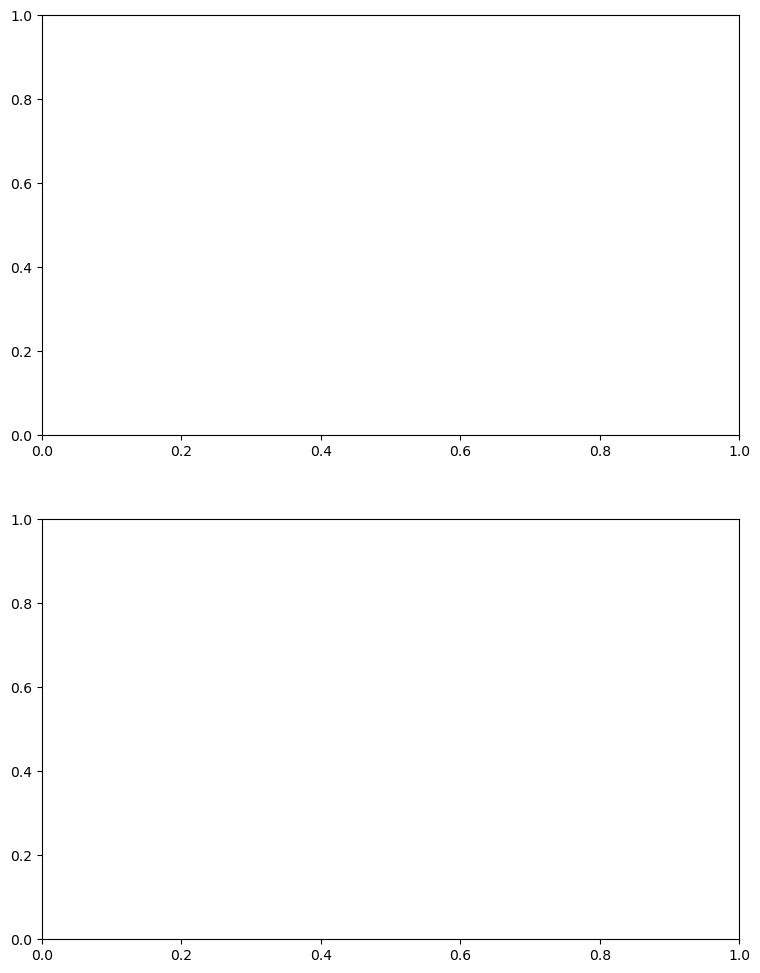

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(9,12))
ax[0].plot(history.history["accuracy"], label="train")
ax[0].plot(history.history["val_accuracy"], label="validation")
ax[0].set_ylim(0,1)
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()
ax[0].set_title("CNN Training with VGG16 Convolution (Larger Dataset)")

ax[1].plot(history.history["loss"], label="train")
ax[1].plot(history.history["val_loss"], label="validation")
ax[1].set_ylim(0,2)
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

fig.savefig("Presentation/images/accuracy_larger_data.png")

In [ ]:
predicted_classes = np.argmax(specific_model.predict(valid_gen), axis=1)

confusionmatrix = confusion_matrix(valid_gen.classes, predicted_classes)
report = classification_report(valid_gen.classes, predicted_classes)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the report as text
ax.text(0, 0, report, ha='left', va='bottom', fontsize=12)
ax.axis('off')

# Save the figure as an image
plt.savefig('Presentation/images/classification_report_cnn.png')

fig, ax = plt.subplots()
sns.heatmap(confusionmatrix, cmap="Blues", annot=True, cbar=True, ax=ax)
fig.savefig("Presentation/images/confusion_matrix_CNN.png")


### Conclusions

The neural net offers a mixed improvement over the manual feature extraction.  Both have roughly the same F1 scores, but the neural net is successfully able to classify images by more specific type.  The classification has more meaning as a result.  

When using **manual feature extraction** with a **decision tree**, the overall **F1 score** was **87%**.  The two smaller classes, lymphocytes and monocytes had an F1 average of 48%.

When using the **pretrained convolutional layer** with a **neural net**, the overall **F1 score** is **78%**.  The two smaller classes, lymphocytes and monocytes have an F1 average of 60%.

#### **Classification Report**: Pretrained Convolution Layer + Neural Net  
<img src="Presentation/images/classification_report_cnn.png">  

#### **Confusion Matrix**: Pretrained Convolution Layer + Neural Net   
<img src="Presentation/images/confusion_matrix_CNN.png" width = 600px>

#### Next Steps

There are additional pretrained convolution nets, such as Resnet50, which may offer improvements over the one used in this network.  For an equal comparison between the two classifiers, the decision tree and neural net, the decision tree classification should be used to classify images by types.